Group-14:
1) Omendra Kumar Upadhyay

In [ ]:
# Install dependencies
!pip install --quiet kaggle
!pip install --quiet segmentation-models-pytorch --no-deps
!pip install --quiet albumentations
!pip install --quiet matplotlib scikit-learn
print("Libraries installed sucessfully !")

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 154.8/154.8 kB 5.8 MB/s eta 0:00:00
Libraries installed sucessfully !


In [ ]:
from google.colab import files
import os

# Upload kaggle.json
print("Upload kaggle.json file:")
files.upload()

# Setup kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




Upload kaggle.json file:


Saving kaggle.json to kaggle.json


In [ ]:
# Download dataset
# REPLACE with your actual dataset slug
dataset_slug = "omendrakumarupadhyay/crack-segmentation-datasetimage-mask"
!kaggle datasets download -d {dataset_slug}


Dataset URL: https://www.kaggle.com/datasets/omendrakumarupadhyay/crack-segmentation-datasetimage-mask
License(s): CC0-1.0


In [ ]:
!unzip -q *.zip -d Crack_Dataset
print("Dataset downloaded and extracted.")

Dataset downloaded and extracted.


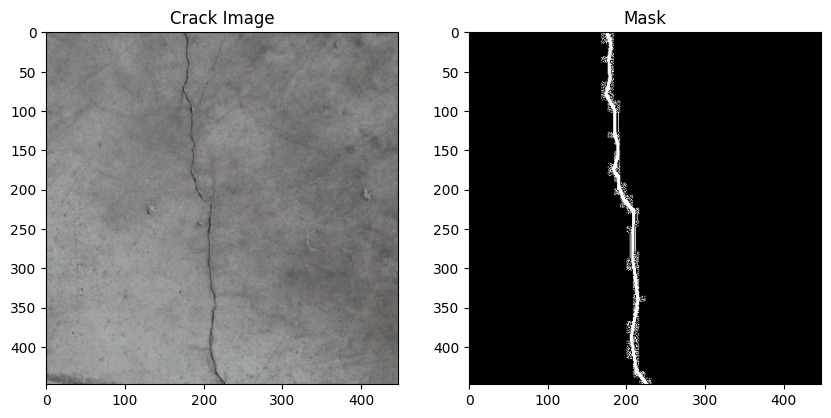

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import glob

image_paths = sorted(glob.glob('Crack_Dataset/Complete Dataset/images/*.jpg'))
mask_paths = sorted(glob.glob('Crack_Dataset/Complete Dataset/masks/*.jpg'))

idx = random.randint(0, len(image_paths)-1)
image = Image.open(image_paths[idx])
mask = Image.open(mask_paths[idx])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Crack Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()


In [ ]:
sizes = set()
for img_path, mask_path in zip(image_paths, mask_paths):
    img_size = Image.open(img_path).size
    mask_size = Image.open(mask_path).size
    sizes.add((img_size, mask_size))

print(f"Unique (Image, Mask) sizes found: {len(sizes)}")
print(sizes)


Unique (Image, Mask) sizes found: 1
{((448, 448), (448, 448))}


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CrackDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [ ]:
# 80% Train, 10% Val, 10% Test
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)

train_loader = DataLoader(CrackDataset(train_imgs, train_masks, transform), batch_size=8, shuffle=True)
val_loader = DataLoader(CrackDataset(val_imgs, val_masks, transform), batch_size=8, shuffle=False)
test_loader = DataLoader(CrackDataset(test_imgs, test_masks, transform), batch_size=8, shuffle=False)

print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")


Train: 9038, Val: 1130, Test: 1130


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt

class GeneralizedDiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = 2.0 * (inputs * targets).sum()
        denominator = inputs.sum() + targets.sum() + self.smooth

        return 1.0 - (intersection / denominator)


class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Compute class weights
        pos_weight = (targets == 0).sum().float() / (targets == 1).sum().float()
        bce_loss = F.binary_cross_entropy(inputs, targets, weight=(targets * pos_weight + (1 - targets)), reduction='mean')

        return bce_loss


class BoundaryLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets):
        # Detach and convert to NumPy
        inputs_np = inputs.squeeze().detach().cpu().numpy()
        targets_np = targets.squeeze().detach().cpu().numpy()

        # Compute distance transform on the ground truth mask
        dist_map = distance_transform_edt(1 - targets_np)

        # Multiply in NumPy space, then return mean as a float
        boundary_term = inputs_np * dist_map
        loss = boundary_term.mean()
        return torch.tensor(loss, dtype=torch.float32, requires_grad=True)




class BoundaryComboLoss(nn.Module):
    def __init__(self, gamma=0.5):
        super().__init__()
        self.gamma = gamma
        self.gdice = GeneralizedDiceLoss()
        self.wce = WeightedCrossEntropyLoss()
        self.boundary = BoundaryLoss()

    def forward(self, inputs, targets, alpha):
        # Apply sigmoid if model output isn't activated
        if not torch.all((inputs >= 0) & (inputs <= 1)):
            inputs = torch.sigmoid(inputs)

        l_b = self.boundary(inputs, targets)
        l_d = self.gdice(inputs, targets)
        l_wce = self.wce(inputs, targets)

        loss = alpha * l_b + (1 - alpha) * ((1 - self.gamma) * l_d + self.gamma * l_wce)
        return loss


In [ ]:
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.PSPNet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm
import os

epochs = 50
checkpoint_dir = "/content/drive/MyDrive/CS_PSPnet_checkpoints/"
os.makedirs(checkpoint_dir, exist_ok=True)

train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_path = ""

# üîÅ Instantiate the BC loss function
bc_loss = BoundaryComboLoss(gamma=0.5)

print("üöÄ Starting training with Boundary Combo Loss...\n")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    val_loss = 0

    alpha = epoch / epochs  # üîÅ Dynamic alpha increases with epoch

    print(f"\nüìò Epoch {epoch+1}/{epochs} | Alpha: {alpha:.4f}")
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for images, masks in train_loader_tqdm:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # ‚ö†Ô∏è Do not apply sigmoid here

        loss = bc_loss(outputs, masks, alpha=alpha)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"‚úÖ Training loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)  # ‚ö†Ô∏è Do not apply sigmoid here
            loss = bc_loss(outputs, masks, alpha=alpha)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"üîç Validation loss: {avg_val_loss:.4f}")

    # Save checkpoint
    checkpoint_path = f"{checkpoint_dir}/pspnet_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"üíæ Model checkpoint saved at: {checkpoint_path}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f"{checkpoint_dir}/PSPnet_best_model.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"üèÜ Best model updated at: {best_model_path}")


üöÄ Starting training with Boundary Combo Loss...


üìò Epoch 1/50 | Alpha: 0.0000


‚úÖ Training loss: 1.1491
üîç Validation loss: 1.0279
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_1.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 2/50 | Alpha: 0.0200


‚úÖ Training loss: 1.0240
üîç Validation loss: 0.9549
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_2.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 3/50 | Alpha: 0.0400


‚úÖ Training loss: 0.9788
üîç Validation loss: 0.9355
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_3.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 4/50 | Alpha: 0.0600


‚úÖ Training loss: 0.9554
üîç Validation loss: 0.9341
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_4.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 5/50 | Alpha: 0.0800


‚úÖ Training loss: 0.8963
üîç Validation loss: 0.8915
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_5.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 6/50 | Alpha: 0.1000


‚úÖ Training loss: 0.8512
üîç Validation loss: 0.8778
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_6.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 7/50 | Alpha: 0.1200


‚úÖ Training loss: 0.8634
üîç Validation loss: 0.8448
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_7.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 8/50 | Alpha: 0.1400


‚úÖ Training loss: 0.8130
üîç Validation loss: 0.8336
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_8.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 9/50 | Alpha: 0.1600


‚úÖ Training loss: 0.7732
üîç Validation loss: 0.8357
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_9.pth

üìò Epoch 10/50 | Alpha: 0.1800


‚úÖ Training loss: 0.7696
üîç Validation loss: 0.8235
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_10.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 11/50 | Alpha: 0.2000


‚úÖ Training loss: 0.7657
üîç Validation loss: 0.7945
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_11.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 12/50 | Alpha: 0.2200


‚úÖ Training loss: 0.7283
üîç Validation loss: 0.8016
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_12.pth

üìò Epoch 13/50 | Alpha: 0.2400


‚úÖ Training loss: 0.7053
üîç Validation loss: 0.7742
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_13.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 14/50 | Alpha: 0.2600


‚úÖ Training loss: 0.6727
üîç Validation loss: 0.7973
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_14.pth

üìò Epoch 15/50 | Alpha: 0.2800


‚úÖ Training loss: 0.6504
üîç Validation loss: 0.7724
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_15.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 16/50 | Alpha: 0.3000


‚úÖ Training loss: 0.6421
üîç Validation loss: 0.7482
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_16.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 17/50 | Alpha: 0.3200


‚úÖ Training loss: 0.6268
üîç Validation loss: 0.7198
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_17.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 18/50 | Alpha: 0.3400


‚úÖ Training loss: 0.6093
üîç Validation loss: 0.7212
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_18.pth

üìò Epoch 19/50 | Alpha: 0.3600


‚úÖ Training loss: 0.5918
üîç Validation loss: 0.7102
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_19.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 20/50 | Alpha: 0.3800


‚úÖ Training loss: 0.5928
üîç Validation loss: 0.6979
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_20.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 21/50 | Alpha: 0.4000


‚úÖ Training loss: 0.5675
üîç Validation loss: 0.7144
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_21.pth

üìò Epoch 22/50 | Alpha: 0.4200


‚úÖ Training loss: 0.5285
üîç Validation loss: 0.6842
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_22.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 23/50 | Alpha: 0.4400


‚úÖ Training loss: 0.5242
üîç Validation loss: 0.6795
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_23.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 24/50 | Alpha: 0.4600


‚úÖ Training loss: 0.5030
üîç Validation loss: 0.6453
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_24.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 25/50 | Alpha: 0.4800


‚úÖ Training loss: 0.5027
üîç Validation loss: 0.6219
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_25.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 26/50 | Alpha: 0.5000


‚úÖ Training loss: 0.4966
üîç Validation loss: 0.6272
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_26.pth

üìò Epoch 27/50 | Alpha: 0.5200


‚úÖ Training loss: 0.4665
üîç Validation loss: 0.6096
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_27.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 28/50 | Alpha: 0.5400


‚úÖ Training loss: 0.4484
üîç Validation loss: 0.5891
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_28.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 29/50 | Alpha: 0.5600


‚úÖ Training loss: 0.4364
üîç Validation loss: 0.6061
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_29.pth

üìò Epoch 30/50 | Alpha: 0.5800


‚úÖ Training loss: 0.4410
üîç Validation loss: 0.5683
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_30.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 31/50 | Alpha: 0.6000


‚úÖ Training loss: 0.4017
üîç Validation loss: 0.5607
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_31.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 32/50 | Alpha: 0.6200


‚úÖ Training loss: 0.4046
üîç Validation loss: 0.5550
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_32.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 33/50 | Alpha: 0.6400


‚úÖ Training loss: 0.3872
üîç Validation loss: 0.5289
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_33.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 34/50 | Alpha: 0.6600


‚úÖ Training loss: 0.3757
üîç Validation loss: 0.5106
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_34.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 35/50 | Alpha: 0.6800


‚úÖ Training loss: 0.3560
üîç Validation loss: 0.5104
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_35.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 36/50 | Alpha: 0.7000


‚úÖ Training loss: 0.3461
üîç Validation loss: 0.5082
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_36.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 37/50 | Alpha: 0.7200


‚úÖ Training loss: 0.3386
üîç Validation loss: 0.4839
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_37.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 38/50 | Alpha: 0.7400


‚úÖ Training loss: 0.3187
üîç Validation loss: 0.4503
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_38.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 39/50 | Alpha: 0.7600


‚úÖ Training loss: 0.3037
üîç Validation loss: 0.4298
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_39.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 40/50 | Alpha: 0.7800


‚úÖ Training loss: 0.2954
üîç Validation loss: 0.3956
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_40.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 41/50 | Alpha: 0.8000


‚úÖ Training loss: 0.2795
üîç Validation loss: 0.3899
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_41.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 42/50 | Alpha: 0.8200


‚úÖ Training loss: 0.2667
üîç Validation loss: 0.3680
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_42.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 43/50 | Alpha: 0.8400


‚úÖ Training loss: 0.2539
üîç Validation loss: 0.3480
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_43.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 44/50 | Alpha: 0.8600


‚úÖ Training loss: 0.2411
üîç Validation loss: 0.3422
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_44.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 45/50 | Alpha: 0.8800


‚úÖ Training loss: 0.2323
üîç Validation loss: 0.3161
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_45.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 46/50 | Alpha: 0.9000


‚úÖ Training loss: 0.2205
üîç Validation loss: 0.2853
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_46.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 47/50 | Alpha: 0.9200


‚úÖ Training loss: 0.2026
üîç Validation loss: 0.2605
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_47.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 48/50 | Alpha: 0.9400


‚úÖ Training loss: 0.1949
üîç Validation loss: 0.2353
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_48.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 49/50 | Alpha: 0.9600


‚úÖ Training loss: 0.1770
üîç Validation loss: 0.2111
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_49.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth

üìò Epoch 50/50 | Alpha: 0.9800


‚úÖ Training loss: 0.1632
üîç Validation loss: 0.1765
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_50.pth
üèÜ Best model updated at: /content/drive/MyDrive/CS_PSPnet_checkpoints//PSPnet_best_model.pth


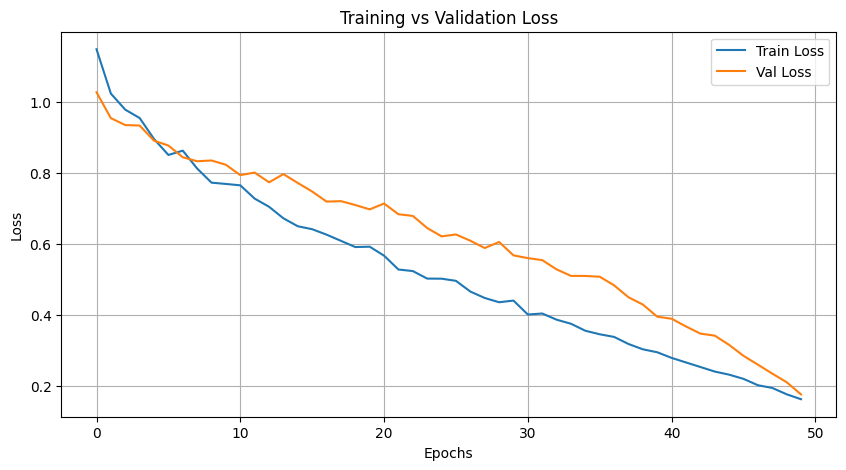

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


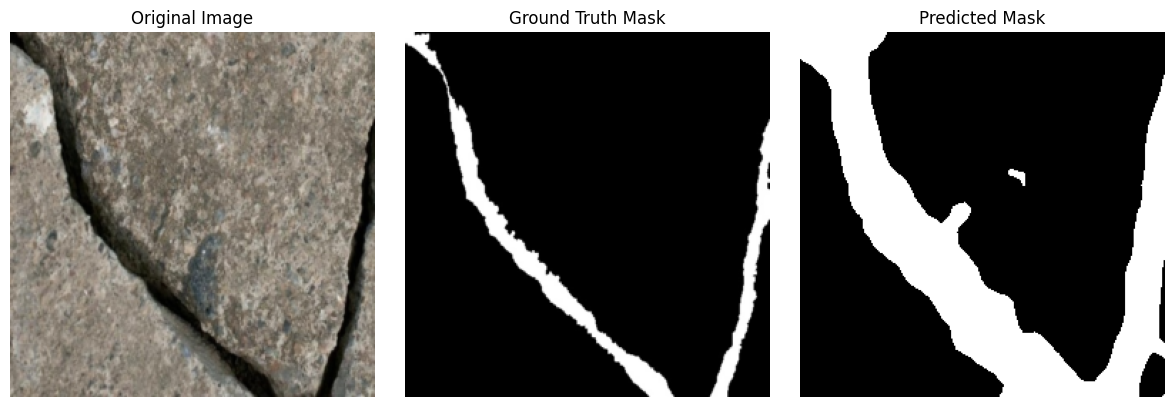

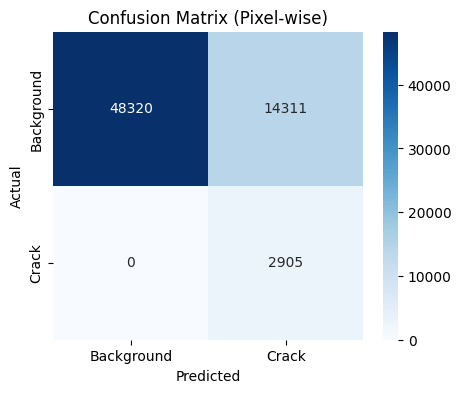

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load best model
best_model_path = "/content/drive/MyDrive/CS_PSPnet_checkpoints/PSPnet_best_model.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# Pick a random index from the test set
rand_idx = random.randint(0, len(test_loader.dataset) - 1)

# Load sample from test dataset (not loader to avoid batching)
image, gt_mask = test_loader.dataset[rand_idx]
image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension

# Predict
with torch.no_grad():
    output = model(image_tensor)
    output = torch.sigmoid(output)
    pred_mask = (output > 0.5).float()

# Prepare numpy arrays
image_np = image.permute(1, 2, 0).cpu().numpy()
gt_mask_np = gt_mask.squeeze().cpu().numpy()
pred_mask_np = pred_mask.squeeze().cpu().numpy()

# ==== Plot Input, Ground Truth, Prediction ====
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_mask_np, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask_np, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# ==== Confusion Matrix (pixel-wise) ====
# Flatten predictions and ground truth for one image
y_true = gt_mask_np.flatten().astype(int)
y_pred = pred_mask_np.flatten().astype(int)

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Background', 'Crack'],
            yticklabels=['Background', 'Crack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Pixel-wise)")
plt.show()


üîç Evaluating model on all test images...

üìä Average Metrics on Test Set:
IoU Score     : 0.0573
F1 Score      : 0.0949
Accuracy      : 0.7452
Precision     : 0.0574
Recall        : 0.8485


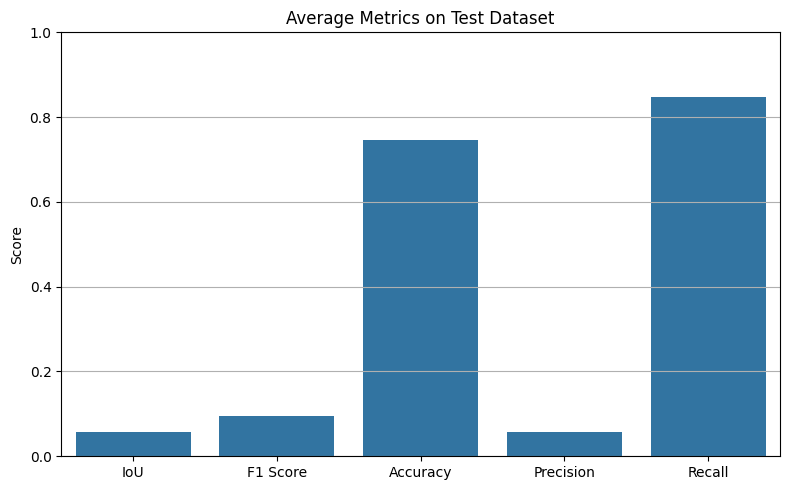

In [ ]:
import torch
import numpy as np
from sklearn.metrics import (
    jaccard_score, f1_score, accuracy_score,
    precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load best model
best_model_path = "/content/drive/MyDrive/CS_PSPnet_checkpoints/PSPnet_best_model.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# Store per-image metrics
ious, f1s, accs, precisions, recalls = [], [], [], [], []

print("üîç Evaluating model on all test images...\n")
with torch.no_grad():
    for image, gt_mask in test_loader.dataset:
        image_tensor = image.unsqueeze(0).to(device)
        gt_mask_tensor = gt_mask.to(device)

        # Predict
        output = model(image_tensor)
        output = torch.sigmoid(output)
        pred_mask = (output > 0.5).float().squeeze().cpu().numpy()
        gt_mask_np = gt_mask_tensor.squeeze().cpu().numpy()

        # Flatten for metric calculation
        y_true = gt_mask_np.flatten().astype(int)
        y_pred = pred_mask.flatten().astype(int)

        # Compute metrics
        ious.append(jaccard_score(y_true, y_pred, zero_division=0))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))
        accs.append(accuracy_score(y_true, y_pred))
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred, zero_division=0))

# Average metrics
avg_iou = np.mean(ious)
avg_f1 = np.mean(f1s)
avg_acc = np.mean(accs)
avg_prec = np.mean(precisions)
avg_recall = np.mean(recalls)

# Print results
print("üìä Average Metrics on Test Set:")
print(f"IoU Score     : {avg_iou:.4f}")
print(f"F1 Score      : {avg_f1:.4f}")
print(f"Accuracy      : {avg_acc:.4f}")
print(f"Precision     : {avg_prec:.4f}")
print(f"Recall        : {avg_recall:.4f}")

# Plot bar chart
metrics = {
    "IoU": avg_iou,
    "F1 Score": avg_f1,
    "Accuracy": avg_acc,
    "Precision": avg_prec,
    "Recall": avg_recall
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Average Metrics on Test Dataset")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


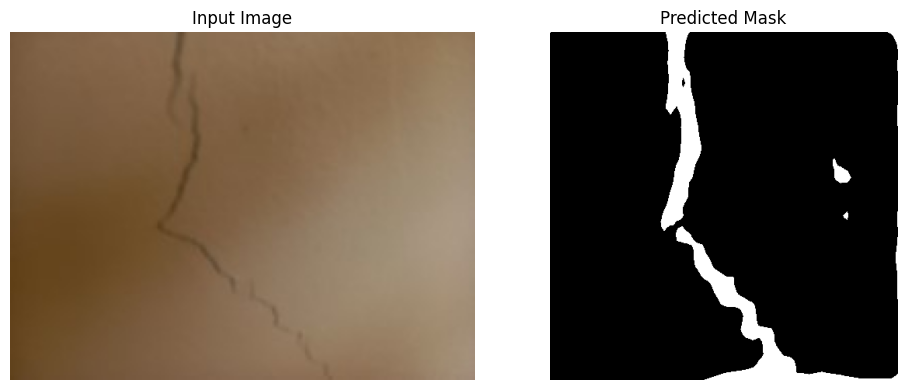

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the best model
best_model_path = "/content/drive/MyDrive/CS_PSPnet_checkpoints/PSPnet_best_model.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# ‚úÖ Image Preprocessing Function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),  # Converts to [0,1] and channels-first
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image, input_tensor

# ‚úÖ Predict Function
def predict_mask(image_path):
    orig_image, input_tensor = preprocess_image(image_path)

    with torch.no_grad():
        output = model(input_tensor)
        output = torch.sigmoid(output)              # Sigmoid for binary mask
        mask = (output > 0.5).float().squeeze().cpu().numpy()  # Threshold & remove batch/channel dims

    return orig_image, mask

# ‚úÖ Provide image path here
image_path = "/content/sample 2.jpg"  # üîÅ Change to your image path
input_image, predicted_mask = predict_mask(image_path)

# ‚úÖ Plot Input Image and Predicted Mask
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
